# Illustrating the Double-Wilson model using surrogate data

The structure factors of related structures are likely to be correlated. We should be able to exploit this correlation during scaling and merging by constraining the optimization more strongly than by the requirement that structure factors following a Wilson distribution. 

The Wilson distribution derives from a model where each structure factor derives from a 1D (centric) or 2D (acentric) random walk on the real axis (centric) or the complex plane (acentric). The amplitudes thereof follow the Wilson distributions. A natural extension would be for the corresponding structure factors of two data sets to perform correlated random walks, resulting in a joint multivariate normal distribution of the real and complex components of the (complex) structure factors of the two data sets. The resulting conditional distributions for structure factor amplitudes are the Woolfson or Folded-normal (centric) and Rice (acentric) distributions as described by Rupp Ch 7.

A key point revealed by the analysis is that the parameter $r_{DW}$ used in the Double-Wilson model is a function of resolution and seems to be well described by the Luzzati model on p. 903 in Read (1990), "Structure-Factor Probabilities for Related Structures". 

**PS**: Although Read's paper is focused on correlations between Fc's rather than Fobs's, its entire analytical apparatus carries over to our case with:

- $r_{DW} = \textbf{D}$ (or $\sigma_E$ in eqs. 28-30).
- his $\textbf{s}$ equal to the reciprocal lattice point vector which I calculate below as (rs_a, rs_b, rs_c).
- his $\sigma^2_{\Delta}$ related to our conditional variance $\frac{1}{2}(1-r_{DW}^2)$.

**Notation**
- we will use $hkl$ and ```HKL```
- we will denote reciprocal lattice point coordinates as ```(rs_a,rs_b,rs_c)``` and $r*$, with magnitude $1/d_{hkl}$ or ```dHKL```. The scattering vector $s=S_1-S_0$ equals $r*$ in our case (elastic scattering).

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import pandas  as pd
from tqdm      import tqdm
plt.rcParams.update({'font.size': 14})

In [71]:
import reciprocalspaceship as rs
import gemmi
from dw_tools       import modify_ds, wilson, plots, fitting_dw
from scipy.optimize import least_squares
from scipy.stats    import rice, foldnorm, vonmises, linregress, pearsonr

In [72]:
#%autosave 300
#%load_ext autoreload
#%autoreload 2
rs.__version__

'0.9.5'

## Mapping from double-wilson $r$ to Pearson corr for $|E|$
We start by making sure we understand the mapping between the parameter $r$ in the Double-Wilson distribution and the actual correlation coefficient between pairs of structure factor amplitudes. To do so, we will analyze samples drawn from the double-wilson distribution described by different values of $r_{DW}$.

In [81]:
nsamples= 1000000
nbin_r  = 20                        # number of values of r_DW to use
r       = np.linspace(0,1,nbin_r)   # r_DW; correlation between random walks 
mean    = [0,0,0,0]                 # mean of random walks

corr_r_ac = np.zeros([nbin_r,1])    # correlation between |F_1| and |F_2| samples from DW (acentric)
for i in tqdm(range(nbin_r)):
    cov     = 0.5*np.asarray([[1,0,r[i],0],[0,1,0,r[i]],[r[i],0,1,0],[0,r[i],0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
    # fake data set (acentric)
    ep1_test = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 )
    ep2_test = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 )
    corr_r_ac[i] = pearsonr(ep1_test, ep2_test)[0]

print("variance of sf acentric amplitudes from the DW distribution:" + \
     str(np.var(np.concatenate((ep1_test,ep2_test)))))
    
corr_r_c = np.zeros([nbin_r,1])
for i in tqdm(range(nbin_r)):
    cov     = 0.5*np.asarray([[1,0,r[i],0],[0,1,0,r[i]],[r[i],0,1,0],[0,r[i],0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
    # fake data set (centric)
    ep1_test = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,0]**2 )
    ep2_test = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,2]**2 )
    corr_r_c[i] = pearsonr(ep1_test, ep2_test)[0]

print("variance of sf acentric amplitudes from the DW distribution:" + \
     str(np.var(np.concatenate((ep1_test,ep2_test)))))
print("Done!")

  0%|                                                   | 0/20 [00:00<?, ?it/s]

variance of sf acentric amplitudes from the DW distribution:0.21491823955873068


100%|██████████████████████████████████████████| 20/20 [00:06<00:00,  3.13it/s]

variance of sf acentric amplitudes from the DW distribution:0.3638881961360799
Done!


It is not _a priori_ obvious what the relationship between the parameter $r$ above and the correlation coefficient of the sf amplitudes should be. Below we'll see that $\rho(|F_1|,|F_2|)\approx r^2$. In the next two cells we look more carefully.

In [82]:
from scipy.linalg import lstsq
M = r[:,np.newaxis]**[2,4,6,8]
beta_ac, res, rnk, s = lstsq(M,corr_r_ac)
beta_c,  res, rnk, s = lstsq(M,corr_r_c )

def r_dw_to_r_E(r,beta):
    X=np.array([r**2,r**4,r**6,r**8]).transpose()
    return np.dot(X,beta)

# despite this function, we'll use the square root as our proxy as it is trivial to invert.
# the coefficients of the least-square fit are quite variable, even with 500,000 samples.

print(beta_ac.transpose())
print(beta_c.transpose())

[[ 0.91737686  0.06009354 -0.01426258  0.03673839]]
[[ 0.8633797   0.16744521 -0.1839032   0.15279447]]


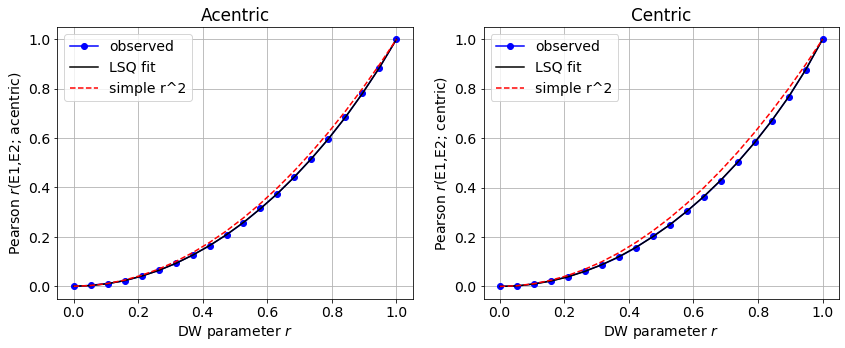

<ipython-input-85-8281c60c5917>:29: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(corr_r_ac, np.sqrt(corr_r_ac+0.15*(corr_r_ac**2-corr_r_ac**3)),'k-')
<ipython-input-85-8281c60c5917>:30: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(corr_r_ac, np.sqrt(corr_r_ac),'r--')


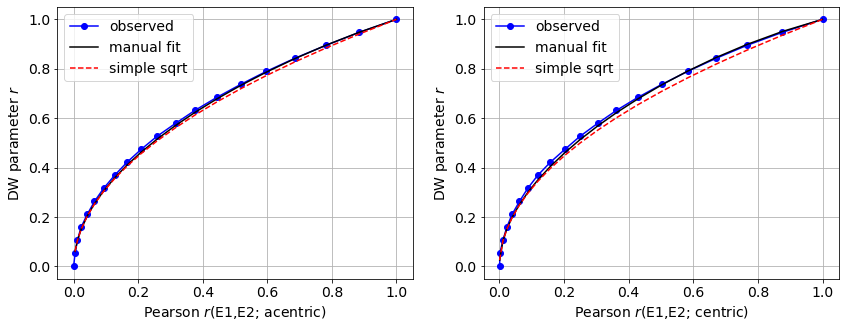

In [85]:
bPlot=True
if bPlot:
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)                       # Empirical and least-squares-fit mapping from r to pearson(E1,E2)
    plt.plot(r,corr_r_ac,'bo-')              # ACENTRIC
    plt.plot(r,r_dw_to_r_E(r,beta_ac),'k-')
    plt.plot(r,r**2,'r--')
    plt.legend(["observed","LSQ fit","simple r^2"])
    plt.xlabel("DW parameter $r$")
    plt.ylabel("Pearson $r$(E1,E2; acentric)")
    plt.title("Acentric")
    plt.grid()

    plt.subplot(1,2,2)                      # CENTRIC
    plt.plot(r,corr_r_c,'bo-')
    plt.plot(r,r_dw_to_r_E(r,beta_c),'k-')
    plt.plot(r,r**2,'r--')
    plt.legend(["observed","LSQ fit","simple r^2"])
    plt.xlabel("DW parameter $r$")
    plt.ylabel("Pearson $r$(E1,E2; centric)")
    plt.title("Centric")
    plt.grid()
    plt.show()

    # now the inverse
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)                       # Empirical and least-squares-fit mapping from r to pearson(E1,E2)
    plt.plot(corr_r_ac,r,'bo-')              # ACENTRIC
    plt.plot(corr_r_ac, np.sqrt(corr_r_ac+0.15*(corr_r_ac**2-corr_r_ac**3)),'k-')
    plt.plot(corr_r_ac, np.sqrt(corr_r_ac),'r--')
    plt.legend(["observed","manual fit","simple sqrt"])
    plt.ylabel("DW parameter $r$")
    plt.xlabel("Pearson $r$(E1,E2; acentric)")
    plt.grid()

    plt.subplot(1,2,2)                       # CENTRIC
    plt.plot(corr_r_c,r,'bo-')
    plt.plot(corr_r_c, np.sqrt(corr_r_c+0.3*(corr_r_c**2-corr_r_c**3)),'k-')
    plt.plot(corr_r_c, np.sqrt(corr_r_c),'r--')
    plt.legend(["observed","manual fit","simple sqrt"])
    plt.ylabel("DW parameter $r$")
    plt.xlabel("Pearson $r$(E1,E2; centric)")
    plt.grid()
    plt.show()

In good approximation, when a pair of normalized structure factors is drawn from an acentric double-wilson distribution, they have a correlation coefficient $r^2_{DW}$, with $r_{DW}$ parametrizing the DW distribution. This approximation is slightly worse for centric reflections.

## Generate and inspect fake Acentric data

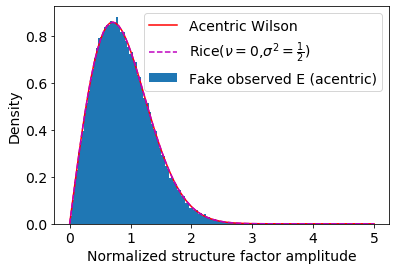

In [86]:
nsamples= 100000
nbin    = 25
x       = np.linspace(0,5,100) # x-coordinates for plots
r_fake  = 0.9                  # correlation between random walks 
r       = r_fake
mean    = [0,0,0,0]            # mean of random walks
cov     = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])

E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)

# fake data set (acentric)
ds_test =         pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 ), columns = ["EP_1"])
ds_test["EP_2"] = pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 ))

# graphical inspection
plt.figure(figsize=(6,4))
plt.hist(ds_test["EP_1"].to_numpy(),100,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x, centric=False),'r-')
plt.plot(x, rice.pdf(x,0,scale=np.sqrt(0.5)),'m--')
plt.legend(["Acentric Wilson", r"Rice($\nu=0$,$\sigma^2=\frac{1}{2}$) ", "Fake observed E (acentric)"])
plt.xlabel("Normalized structure factor amplitude")
plt.ylabel("Density")
plt.show()

## Generate and inspect fake Centric data

EP_1    0.798407
EP_2    0.797247
dtype: float64


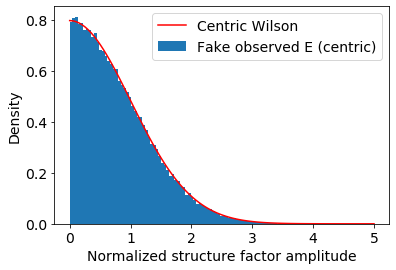

In [87]:
# fake data set (centric)
# mind the sqrt(2)! we normalize, in effect, by the rms acentric amplitude
ds_test_cent = pd.DataFrame(        np.sqrt(2*E_1x_1y_2x_2y[:,0]**2), columns = ["EP_1"])
ds_test_cent["EP_2"] = pd.DataFrame(np.sqrt(2*E_1x_1y_2x_2y[:,2]**2))

print(ds_test_cent.mean())
# graphical inspection
plt.figure()
plt.hist(ds_test_cent["EP_2"].to_numpy(),100,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x, centric=True),'r-')
plt.legend(["Centric Wilson", "Fake observed E (centric)"])
plt.xlabel("Normalized structure factor amplitude")
plt.ylabel("Density")
plt.show()

## Conditional distribution for Acentrics. 
### Step 1: means per bin for $|E_1|$.

Number of reflections per bin:
{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000, 10: 4000, 11: 4000, 12: 4000, 13: 4000, 14: 4000, 15: 4000, 16: 4000, 17: 4000, 18: 4000, 19: 4000, 20: 4000, 21: 4000, 22: 4000, 23: 4000, 24: 4000, 25: 4000}


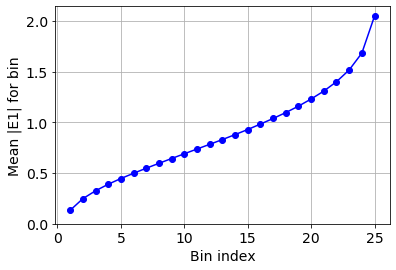

In [88]:
cdf_bins = np.linspace(0,100,nbin+1)
ep1_bins = np.percentile(ds_test["EP_1"], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig  = np.digitize(ds_test["EP_1"], ep1_bins)
ds_test["EP_1_bin"] = ep1_dig.flatten()

unique, counts = np.unique(ds_test["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means=ds_test.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.grid(True)
plt.ylim(0,)
plt.show()

### Step 2: histograms of $|E_2|$ per bin of $|E_1|$.
The calculations of the parameters for the Rice distribution are not very intuitive. 

The conditional mean     $\mathbb{E}\left(E_2 | E_1\right) = r_{DW} E_1$ (for both centric and acentric; true for amplitudes and complex structure factors).

The conditional variance $\textrm{Var}\left(|E_2| | |E_1| \right) = \frac{1}{2}\left(1-r_{DW}^2\right)$ (acentric)
or                                                                           $\left(1-r_{DW}^2\right)$ (centric),
where the twice-as-large conditional variance for centrics is inherent in how they are calculated.

<ipython-input-89-493b54e2927a>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,5,3)


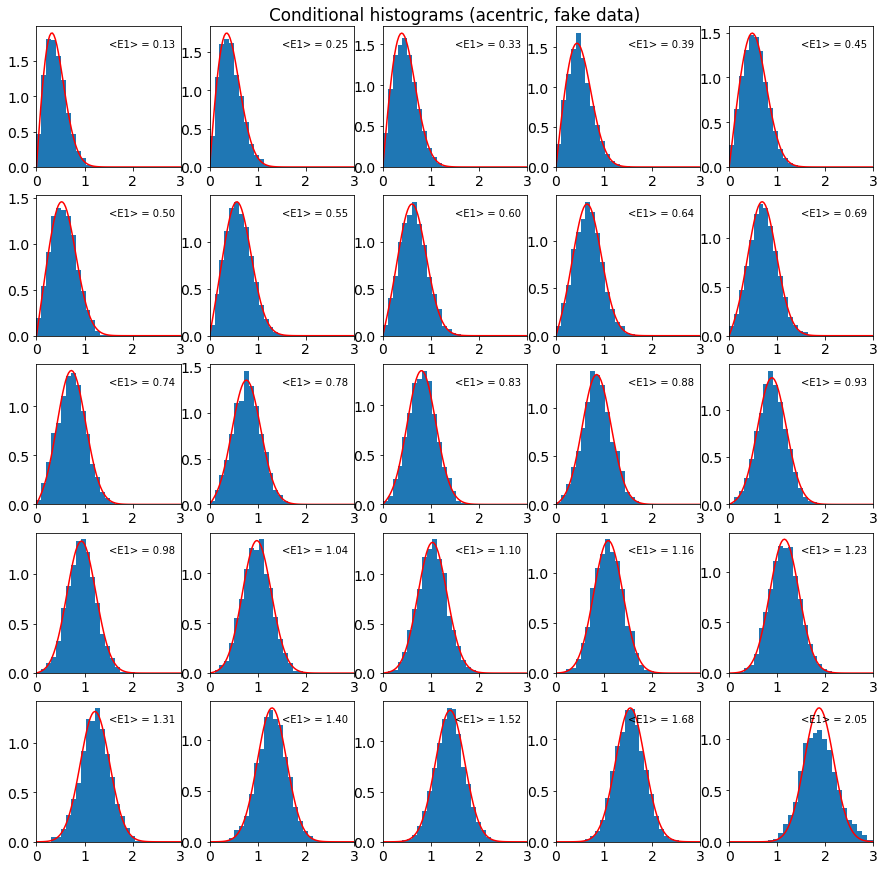

In [89]:
plt.figure(figsize=(15,15)) 
x=np.linspace(0,3,100)
counter = 0
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r1 = r_fake*bin_means[i]     # conditional exp value
    cond_var = 0.5*(1-r_fake**2) # conditional var for acentrics

    plt.hist(ds_test.loc[ds_test["EP_1_bin"]==i,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()
    xl=[0,3] 
    plt.text(1.5,0.85*yl[1],f"<E1> = {bin_means[i]:.2f}",size=10)
    plt.xlim(xl)
 
plt.subplot(5,5,3)
plt.title("Conditional histograms (acentric, fake data)")
plt.show()

#### Illustrating how the Rice distribution interpolates between the reference and the Wilson disitrbution
A more detailed closeup of a few of them. 
- **Black**: the average reference value in a bin; 
- Blue:  the unconditional mean (i.e. the Wilson mean); 
- Red:   the conditional mean

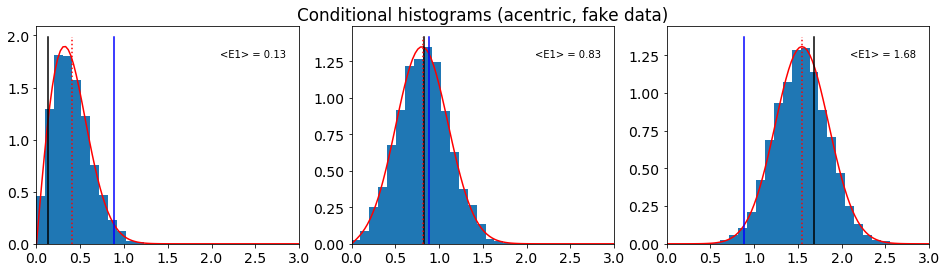

In [90]:
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
counter = 0
for i in [1, 13, 24]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r1 = r_fake*bin_means[i]     # conditional exp value
    cond_var = 0.5*(1-r_fake**2) # conditional var for acentrics
    
    plt.hist(ds_test.loc[ds_test["EP_1_bin"]==i,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()

#    to illustrate the idea of Rice interpolating between Wilson and delta function:
    plt.plot(bin_means[i]*np.asarray([1, 1]),yl,'k-')
    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.text(2.1,0.9*yl[1],f"<E1> = {bin_means[i]:.2f}",size=10)
    plt.xlim(xl)
    if counter == 2:
        plt.title("Conditional histograms (acentric, fake data)")
 
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

## Conditional distribution for Centrics. 
### Step 1: means per bin for $|E_1|$.

Number of reflections per bin:
{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000, 10: 4000, 11: 4000, 12: 4000, 13: 4000, 14: 4000, 15: 4000, 16: 4000, 17: 4000, 18: 4000, 19: 4000, 20: 4000, 21: 4000, 22: 4000, 23: 4000, 24: 4000, 25: 4000}


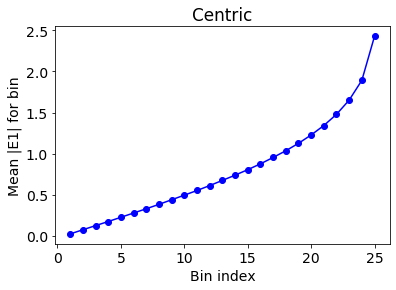

In [91]:
cdf_cent_bins     = np.linspace(0,100,nbin+1)
ep1_cent_bins     = np.percentile(ds_test_cent["EP_1"], cdf_cent_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_cent_dig  = np.digitize(ds_test_cent["EP_1"], ep1_cent_bins)
ds_test_cent["EP_1_bin"] = ep1_cent_dig.flatten()

unique, counts = np.unique(ds_test_cent["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means_cent=ds_test_cent.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_cent,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.title("Centric")
plt.show()

### Step 2: histograms of $|E_2|$ per bin of $|E_1|$.

<ipython-input-92-1186bb1fe8e4>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,5,3)


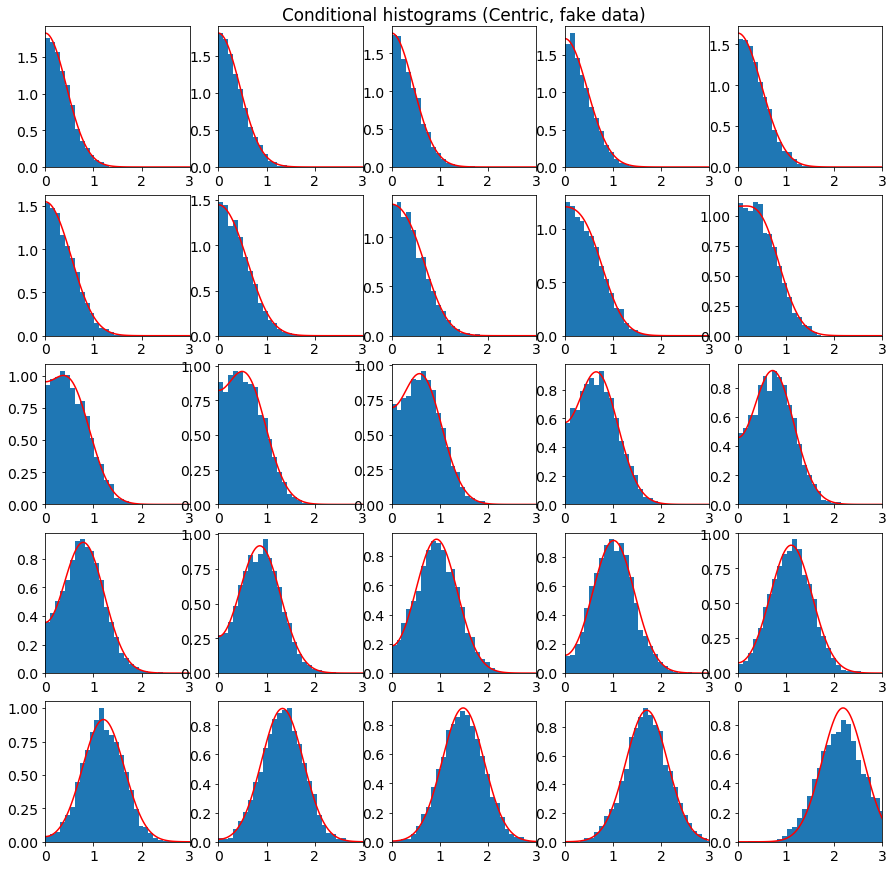

In [92]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r1 = r_fake*bin_means_cent[i] # conditional exp value
    cond_var = (1-r_fake**2)      # no 0.5* for centrics!
    plt.hist(ds_test_cent["EP_2"][ds_test_cent["EP_1_bin"]==i],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] #plt.xlim()
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms (Centric, fake data)")
plt.show()

## Read in reference data
We'll use these to set some of the parameters of the surrogate data

In [135]:
path="double_wilson_data/"    # Unix
data_set_pairs = [("5kvx_phases", "5kw3_phases"),\
                  ("5e1y_phases", "2vwr_phases"),\
                  ("3pyp_phases", "1nwz_phases"),\
                  ("1otb_phases", "1nwz_phases"),\
                  ("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll")]
# example 1 fails on kNN regression
example=2
mtz1 = data_set_pairs[example][0] # omit .mtz
mtz2 = data_set_pairs[example][1]
ds1 = rs.read_mtz(path + mtz1 + "_scaled.mtz")
ds2 = rs.read_mtz(path + mtz2 + "_scaled.mtz")

In [136]:
ds1_2= ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2.label_centrics(inplace=True)
if True:
    modify_ds.ds_high_res_cut(ds1_2, rescut=1.2, inplace=True)

EP1_label = "EP_1_aniso_2_1"
EP2_label = "EP_1_aniso_2_2"
dHKL_label= "dHKL_1"

Let's take a look at the histograms. There are some systematic deviations.

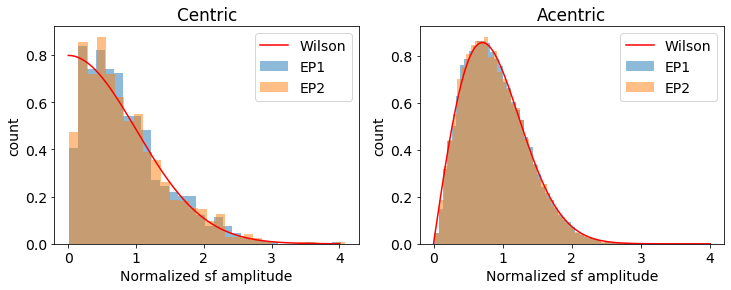

1.0553881
1.061106
0.9974287
0.9916619


In [137]:
bPlot=True
if bPlot:
    ep1   =ds1_2[   "EP_1_aniso_2_1"]
    ep2   =ds1_2[   "EP_1_aniso_2_2"]
    sigep1=ds1_2["SIGEP_1_aniso_2_1"]
    sigep2=ds1_2["SIGEP_1_aniso_2_2"]
    sigcut=0.2

    x=np.linspace(0,4,150)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(ep1[(ds1_2["CENTRIC"]==True) & (sigep1<sigcut)],30,alpha=0.5,density=True,label="EP1")
    plt.hist(ep2[(ds1_2["CENTRIC"]==True) & (sigep2<sigcut)],30,alpha=0.5,density=True,label="EP2")
    plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-',label="Wilson") 
    plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
    plt.legend(); plt.title("Centric")

    plt.subplot(1,2,2)
    plt.hist(ep1[(ds1_2["CENTRIC"]==False) & (sigep1<sigcut)],50,alpha=0.5,density=True,label="EP1")
    plt.hist(ep2[(ds1_2["CENTRIC"]==False) & (sigep2<sigcut)],50,alpha=0.5,density=True,label="EP2")
    plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-',label="Wilson")
    plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
    plt.legend(); plt.title("Acentric")
    plt.show()

    print(np.mean(ep1[ds1_2["CENTRIC"]==True]**2))
    print(np.mean(ep2[ds1_2["CENTRIC"]==True]**2))
    print(np.mean(ep1[ds1_2["CENTRIC"]==False]**2))
    print(np.mean(ep2[ds1_2["CENTRIC"]==False]**2))

### Expected correlation coefficients under experimental errors
Note: currently this redefines some variables from fake to real data.

We begin by looking at how the normalized structure factors are distributed by percentile bin as a function of resolution. We typically see that the central bins are _overrepresented_ at high resolution, where the effects of French-Wilson scaling are _very_ pronounced. Conversely, low-E values are _underrepresented_, presumably for the same reason. Setting a sigmacut for errors in the normalized structure factors really drives this home.

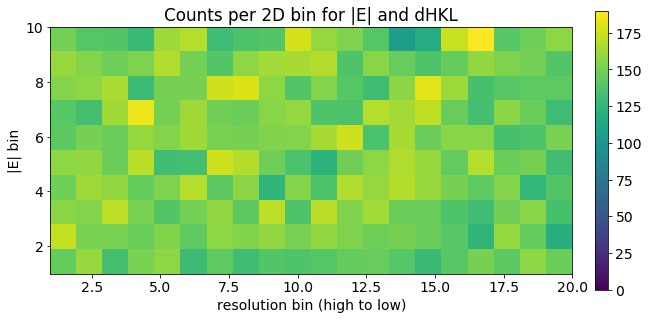

In [138]:
# Let's examine the distribution of dHKL and E in the real data
sig_cut = 1
nbin    = (20,10)
dHKL_bin_label="dHKL_bin"

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1_2["dHKL_1"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1_2["dHKL_1"], d_bins)
ds1_2[dHKL_bin_label] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1_2[EP1_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1_2[EP1_label], ep1_bins)
ds1_2["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(ds1_2.loc[(ds1_2["CENTRIC"]==False) & (ds1_2["SIG" + EP1_label]<sig_cut), dHKL_bin_label], \
                                   ds1_2.loc[(ds1_2["CENTRIC"]==False) & (ds1_2["SIG" + EP1_label]<sig_cut), "EP_1_bin"],bins=nbin)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)
plt.show()

## Effect of measurement error on apparent correlations
### Resampling experimental measurement errors
We will assign our surrogate data measurement errors sampled from actual data.

In [139]:
# resample experimental standard deviations
count_max = 10*np.max(H[:]).astype(int)
print(count_max)
sigE_samples = np.zeros([nbin[0],nbin[1],count_max])
replace = True    # sample with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

for i in range(nbin[0]):      # resolution
    for j in range(nbin[1]):  # E bin
        sigE_samples[i][j] = ds1_2.loc[(ds1_2[dHKL_bin_label]==i+1)&(ds1_2["EP_1_bin"]==j+1),"SIG" + EP1_label].sample(count_max,replace=replace).to_numpy()

1900


In [140]:
# initialize an array for fake data with experimental standard deviations and to-be-imposed covariance structure
ds1_2_fake=ds1_2[[dHKL_bin_label,"CENTRIC"]].copy()
ds1_2_fake[dHKL_label] = ds1_2[dHKL_label].copy()
ds1_2_fake.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 31413 entries, (0, 1, 3) to (47, 1, 3)
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dHKL_bin  31413 non-null  int64  
 1   CENTRIC   31413 non-null  bool   
 2   dHKL_1    31413 non-null  MTZReal
dtypes: MTZReal(1), bool(1), int64(1)
memory usage: 621.3 KB


### Correlations should be resolution-dependent
The correlation coefficient for simulated data with a single global correlation coefficient drops off much more slowly than for the observations. This seems to imply two things: 

1. Measurement errors are wildly overestimated at low resolution, and perhaps underestimated at high resolution, **and/or**
2. The correlation coefficient should really be considered resolution-dependen

The latter is far more plausible. Indeed, R. Read, 1990 "Structure-Factor Probabilities for Related Structures" confirms this perspective and suggests a form $\rho=a e^{-b s^2}$. Based on that paper, **in case of isotropic, normally distributed coordinate shifts**, $b\sim \frac{2\pi^2}{3} \left< |\Delta r_j|^2\right>$. For example, $b=1$ corresponds to a root mean square coordinate shift (in 3D) of $\sqrt{\left< |\Delta r_j|^2\right>} =\frac{1}{\pi} \sqrt{3/2}$ = 0.4 A. More generally, the assumed rms coordinate shift is $0.39 \sqrt{b}$ in Angstrom. In this model, $a=1$.

### Surrogate data with resolution-dependent correlation and resampled expt errors
We'll implement resolution-dependent sampling of E2 given E1 for fake data structured like the real data. 
_Note_: we'll come up with a way to determine _a_ and _b_ from experimental data below.

In [142]:
acentric = (ds1_2_fake["CENTRIC"].to_numpy() == False)
centric  = (ds1_2_fake["CENTRIC"].to_numpy() == True )
count_by_bin_ac = ds1_2_fake.loc[acentric, dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).count().to_numpy()
res_means_ac    = ds1_2_fake.loc[acentric, dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).mean( ).to_numpy()
count_by_bin_c  = ds1_2_fake.loc[centric,  dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).count().to_numpy()
res_means_c     = ds1_2_fake.loc[centric,  dHKL_label].groupby(ds1_2_fake[dHKL_bin_label]).mean( ).to_numpy()
print(count_by_bin_ac)
print(count_by_bin_c)

a=1                   # per Read, 1990, one expects a=1 for isotropic coordinate changes drawn from a normal dist
b=1e-9
mean    = [0,0,0,0]            # mean of random walks
ds1_2_fake["EP_2"] = np.zeros(ds1_2_fake.shape[0])
ds1_2_fake["EP_1"] = np.zeros(ds1_2_fake.shape[0])
for i in range(nbin[0]):       # loop over resolution bins
    # let's generate acentric pairs (the assignments to parts of columns create warnings)
    r = a*np.exp(-b/(res_means_ac[i]**2))
    cov           = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=count_by_bin_ac[i])
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & acentric, "EP_1"] = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 )
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & acentric, "EP_2"] = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 )
    
    # now for centric pairs
    r = a*np.exp(-b/(res_means_c[i]**2))
    cov           = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=count_by_bin_c[i])
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & centric,"EP_1"] = np.sqrt(2*E_1x_1y_2x_2y[:,0]**2)
    ds1_2_fake.loc[(ds1_2_fake[dHKL_bin_label]==i+1) & centric,"EP_2"] = np.sqrt(2*E_1x_1y_2x_2y[:,2]**2)


[1530 1528 1526 1523 1521 1521 1525 1526 1513 1516 1515 1513 1508 1511
 1502 1498 1493 1480 1461 1395]
[ 41  43  44  48  49  49  47  44  58  53  56  59  61  61  67  74  78  88
 112 176]


In [143]:
ep1_fake_bins = rice.ppf(np.linspace(0,0.999,nbin[1]+1),0,0,np.sqrt(0.5))
ep1_fake_bins[-1] = 100
ep2_fake_bins = rice.ppf(np.linspace(0,0.999,nbin[1]+1),0,0,np.sqrt(0.5))
ep2_fake_bins[-1] = 100

ep1_fake_dig  = np.digitize(ds1_2_fake["EP_1"], ep1_fake_bins)
ep2_fake_dig  = np.digitize(ds1_2_fake["EP_2"], ep2_fake_bins)
# print(plt.hist(ep2_fake_dig)) # these bins are not great for fake data

In [144]:
# Construct an array of fake measurements with the same EP1 and dHKL bins as the data
# we're assuming that the same error distribution applies to normalized centric and acentric structure factors.
S = ds1_2_fake.shape[0]
ep1_fake_obs    = np.zeros((S,))
sig_ep1_fake_obs= np.zeros((S,))
count_array     = np.zeros(nbin).astype(int)
for i in tqdm(range(S)):
    i_E    = ep1_fake_dig[i] - 1
    i_dHKL = ds1_2_fake.iloc[i][dHKL_bin_label] - 1
    i_dHKL = i_dHKL.astype(int)                       
    sigma  = sigE_samples[i_dHKL][i_E][count_array[i_dHKL][i_E]]
    loc    = ds1_2_fake.iloc[i]["EP_1"]
    count_array[i_dHKL][i_E] += 1
    ep1_fake_obs[i]           = np.random.normal(loc=loc,scale=sigma)
    sig_ep1_fake_obs[i]       = sigma
    
ds1_2_fake["EP_1_obs"   ] = ep1_fake_obs
ds1_2_fake["SIGEP_1_obs"] = sig_ep1_fake_obs

# same for the other one, we continue counting in the counting array
# i.e. uncorrelated errors (errors may well be correlated in reality!)
ep2_fake_obs= np.zeros((S,))
sig_ep2_fake_obs= np.zeros((S,))
for i in tqdm(range(S)):
    i_E    = ep2_fake_dig[i] - 1
    i_dHKL = ds1_2_fake.iloc[i][dHKL_bin_label] - 1
    i_dHKL = i_dHKL.astype(int)                       # for some reason, the last one or two are corrupted
    sigma  = sigE_samples[i_dHKL][i_E][count_array[i_dHKL][i_E]]
    loc    = ds1_2_fake.iloc[i]["EP_2"]
    count_array[i_dHKL][i_E] += 1
    ep2_fake_obs[i]           = np.random.normal(loc=loc,scale=sigma)
    sig_ep2_fake_obs[i]       = sigma
    
ds1_2_fake["EP_2_obs"]=ep2_fake_obs
ds1_2_fake["SIGEP_2_obs"]=sig_ep2_fake_obs

100%|██████████████████████████████████| 31413/31413 [00:09<00:00, 3396.00it/s]


Let's plot these "observed" (i.e. with measurement error) fake data. The way this is calculated, they can be a little negative.

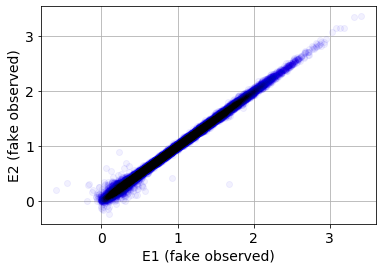

In [145]:
plt.plot(ds1_2_fake["EP_1_obs"].to_numpy(), ds1_2_fake["EP_2_obs"].to_numpy(),'bo',alpha=0.05)
plt.plot(ds1_2_fake["EP_1_obs"].to_numpy(), ds1_2_fake["EP_2_obs"].to_numpy(),'ro',alpha=0.002)
plt.xlabel("E1 (fake observed)")
plt.ylabel("E2 (fake observed)")
plt.grid(); plt.show()

### Relating expected correlation under DW to correlation under measurement error

The next step is to relate the expected correlation coefficient under the double-Wilson model to the expected correlation coefficient when we add in measurement error. The underlying model is as follows: For each $hkl$, we'll consider that for the first model, the true structure factor amplitudes are $EP1_{true}=x$ and $EP2_{true}=x+\epsilon$. That is, $\epsilon$ captures fixed effects. Instead, we observe $EP1_{obs}=x+\eta_1$ and $EP2_{obs}=x+\epsilon + \eta_2$ with $\eta_1$ and $\eta_2$ the measurement errors. It does not matter whether the errors are truely additive--these relationships can be considered to define $\eta_1$ and $\eta_2$. We will assume that the reported errors are accurate estimates of the standard deviations of  $\eta_1$ and $\eta_2$. 

Then,

$\rho_{obs} = \rho(x+\eta_1,x+\epsilon+\eta_2)=\frac{\sigma_x^2}{\sqrt{\left(\sigma_x^2 + \sigma_1^2 \right)                  
                                                                       \left(\sigma_x^2 + \sigma_\epsilon^2
                                                                                        + \sigma_2^2\right)}
                                                                       }$ 
and 
$\rho_{true}= \rho(x,x+\epsilon)=\frac{\sigma_x^2}{\sqrt{\sigma_x^2 \left(\sigma_x^2+\sigma_\epsilon^2\right)}}$

where we've used that all covariances between $x,\epsilon,\eta_1,\eta_2$ are 0 (except "self-covariance") and abbreviated error std's as $\sigma_1$ and $\sigma_2$. Some algebra yields:

$\rho_{obs}^{-2} = \rho_{true}^{-2} + \frac{\sigma^2_1+\sigma^2_2}{\sigma^2_x} + \frac{\sigma^2_1 \sigma^2_2}{\sigma^4_x} + \frac{\sigma^2_1}{\sigma^2_x}\left(\rho_{true}^{-2}-1 \right)$

Since it is arbitrary to assign the systematic effects to dataset 2 rather than dataset 1, we symmetrize the last term below to $\frac{\sigma_1\sigma_2}{\sigma^2_x}\left(\rho_{true}^{-2}-1 \right)$.

Note that $\sigma^2_x$ is, in our model, the variance of the Wilson distribution for normalized structure factors. This variance differs between centric and acentric wilson distributions. For simplicity, I use below estimates obtained above by sampling. Because the estimated $\rho_{obs}$ depends on error estimates of structure factor amplitudes, we estimate it below *for each observed normalized structure factor*.

So far, we've assumed some *a and b*. We'll now put all the calculations above together into a fitting routine (see ```fitting_dw.py```). For simplicity, we approximate the correlation between error-less normalized structure factor amplitudes under the model as $\rho_{DW}=r^2_{DW}$. Let's compare the data to our double-wilson model with resolution-dependent $r_{DW}$, either using the sampling procedure described first, or the (almost) analytical fitting procedure in ```fitting_dw.py```.

In [146]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print("a: " + str(a))
print("b: " + str(b))

`gtol` termination condition is satisfied.
Function evaluations 13, initial cost 7.4598e+00, final cost 2.8728e-03, first-order optimality 4.37e-09.
a: 0.996578819262162
b: 1.8317324677523075e-08


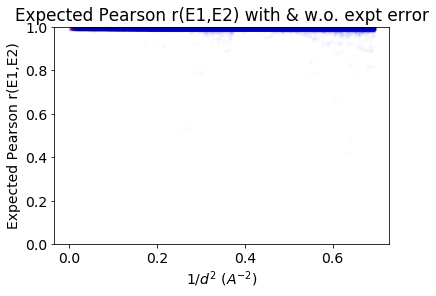

In [147]:
d          = ds1_2_fake[dHKL_label].to_numpy()
r_by_res   = a*np.exp(-b/(d**2))                  # DW r
r_by_res   = r_by_res.flatten()
rho_no_err = r_dw_to_r_E(r_by_res,beta_ac)        # rho from DW r; treat all as acentric (small error); almost rho=r**2
rho_no_err = rho_no_err.flatten()

varW_acentric= rice.var(0,0,np.sqrt(0.5))
varW_centric = foldnorm.var(0,0,1)
tmp1         = ds1_2_fake["SIGEP_1_obs"].to_numpy()**2 # 
tmp2         = ds1_2_fake["SIGEP_2_obs"].to_numpy()**2 # 
quad_var_E   = tmp1+tmp2

rho_w_err_inv2_ac = (1/rho_no_err**2) + quad_var_E/varW_acentric +\
                   tmp1*tmp2/varW_acentric**2 + ((1/rho_no_err**2)-1)*np.sqrt(tmp1*tmp2)/varW_acentric
rho_w_err_inv2_c  = (1/rho_no_err**2) + quad_var_E/varW_centric +\
                   tmp1*tmp2/varW_centric**2  + ((1/rho_no_err**2)-1)*np.sqrt(tmp1*tmp2)/varW_centric

rho_w_err_ac = 1/np.sqrt(rho_w_err_inv2_ac) #(rho_no_err**2/(1+rho_no_err**2  + (tmp**2)/(varW_acentric)))
rho_w_err_c  = 1/np.sqrt(rho_w_err_inv2_c)  #(rho_no_err**2/(1+rho_no_err**2  + (tmp**2)/(varW_acentric)))

ds1_2_fake["Exp rho w error"]=np.nan
ds1_2_fake.loc[acentric,"Exp rho w error"] = rho_w_err_ac[acentric]
ds1_2_fake.loc[centric, "Exp rho w error"] = rho_w_err_c[  centric]

plt.plot(1/d**2, rho_no_err, 'r.',alpha=0.01)
plt.plot(1/d**2, rho_w_err_ac, 'b.',alpha=0.01)
plt.title('Expected Pearson r(E1,E2) with & w.o. expt error')
plt.xlabel(r"$1/d^2$ ($A^{-2}$)")
plt.ylabel("Expected Pearson r(E1,E2)")
plt.ylim((0,1))
plt.show()

We now calculate a weighted-average expected correlation coefficient under the model just described.

In [148]:
ds=ds1_2_fake # view for brevity
rho_avg=np.zeros((20,1))
for i in range(ds[dHKL_bin_label].min(),ds[dHKL_bin_label].max()+1):
    boi = (ds[dHKL_bin_label]==i) # bin of interest
    rho = ds.loc[boi,"Exp rho w error"].to_numpy()
    w   = (ds.loc[boi,"SIGEP_1_obs"]*ds["SIGEP_2_obs"][boi]).to_numpy()
    tmp = np.sum(w*rho)/np.sum(w)
    rho_avg[i-1] = np.sum(w*rho)/np.sum(w) # np.mean(rho) gives nearly the same results

Let's compare our correlation coefficients.

Average observations per bin: 1570.65
Average observations per bin: 1570.65


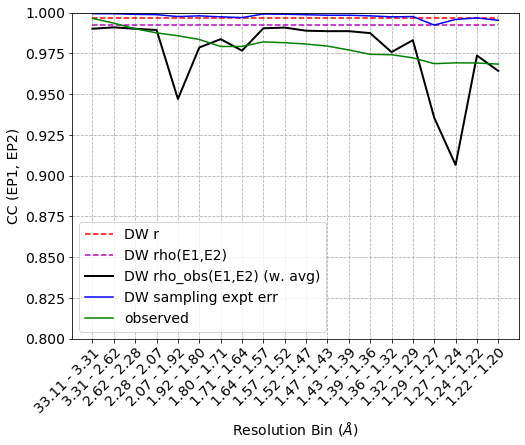

In [150]:
result_1, labels_1 = plots.compute_cc(ds1_2_fake,labels=["EP_1_obs","EP_2_obs"],nbins=20,method="pearson")
result_3, labels_3 = plots.compute_cc(ds1_2,     labels=[EP1_label,  EP2_label],nbins=20,method="pearson")

# we'll reverse-engineer Jack's labels to add the expected curve in the absence of expt error
res_range = np.zeros([20,1])
for i in range(len(labels_1)):
    tmp1 = float(labels_1[i].split()[0])
    tmp3 = float(labels_1[i].split()[2])
    tmp2 = np.sqrt(tmp1*tmp3) # geom mean
    res_range[i] = tmp2
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(20), a*np.exp(-b/(res_range**2)),'r--')
plt.plot(np.arange(20), r_dw_to_r_E(a*np.exp(-b/(res_range**2)),beta_ac).flatten(),'m--') # this is correct for acentrics
plt.plot(np.flip(np.arange(20)), rho_avg, 'k-',linewidth=2)
plots.plot_by_res_bin(result_1, labels_1)
plots.plot_by_res_bin(result_3, labels_3,color='g')
plt.legend(["DW r", "DW rho(E1,E2)", "DW rho_obs(E1,E2) (w. avg)", "DW sampling expt err", "observed"])
plt.ylim(0.8,1)
plt.ylabel("CC (EP1, EP2)")
plt.show()

We see that the correlation coefficient in this data set is dominated by the true differences in structures (magenta), with small contributions from experimental error (observed: green; fake data, resampled: blue; model estimate using experimental errors: black).